<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="800">

# Домашнее задание 5: АБ-тест
</center>

**ФИО:** Ковель Александр Денисович

## Общая информация

__Дата выдачи:__ 07.04.2025

__Дедлайн:__ 23:59MSK 20.04.2025

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

На семинаре мы попытались разобраться как устроена процедура АБ-тестирования. В этом задании мы попытаемся закрепить полученные знания и более аккуратно структурировать их.

### Кратко повторим теорию

Мы хотим выктить новую функциональность на сайте. Перед раскаткой нам хочется проверить, какой эффект мы оказываем на пользователя. Выделим две выборки: тестовую (treatment) и контрольную (control). Тестовой покажем новый сайт. Контрольной старый. Замерим инетерсующую нас метрику, нааример, время проведенной на сайте, в обеих группах:

$$
\begin{aligned}
&X^c_1, \ldots, X^c_{n_c} \sim iid (\mu_c, \sigma^2_c) \\
&X^t_1, \ldots, X^t_{n_t} \sim iid (\mu_t, \sigma^2_t)
\end{aligned}
$$

У выборок есть какие-то математические ожидания, дисперсии. Выборки собраны независимо друг от друга. Если их математические ожидания одинаковые, будем считать, что новая функциональность никак не повлияла на пользователей. Сформулируем это в виде нашей нулевой гипотезы:

$$
\begin{aligned}
&H_0: \hspace{2mm} \mu_c = \mu_t \\
&H_1: \hspace{2mm} \mu_c < \mu_t.
\end{aligned}
$$

Посчитаем по выборке расстояние между математическими ожиданиями $\hat \mu_t - \hat \mu_c$. Оно по ЦПТ имеет нормальное распределение с оценкой дисперсии $\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}$. Получается, что

$$
z = \frac{\hat \mu_t - \hat \mu_c}{\sqrt{\frac{\hat{\sigma}^2_t}{n_t} + \frac{\hat{\sigma}^2_c}{n_c}}} \sim N(0,1),
$$

при верности нулевой гипотезы и $n \to \infty$. Если это расстояние оказывается слишком большим, мы отказываемся верить в нулевую гипотезу. Эффект от новой функциональности есть. Будем сравнивать наблюдаемое значение $z$ с $z_{1 - \alpha},$ где уровень значимости $\alpha$ выберем до начала эксперимента.

- Если $z < z_{1 - \alpha},$ нулевая гипотеза не отвергается (похоже, что верна). Расстояние маленькое, разницы нет.
- Если $z > z_{1 - \alpha},$ выбираем альтернативу. У на есть значимый эффект на метрику, от веры в нулевую гипотезу придётся отказаться.

> Ничего не понятно? Тогда вам в лекции. Ниже подборка:  

- [Наша лекция про АБ]( )
- [Неделя про проверку гипотез с курсеры](https://www.youtube.com/watch?v=Zv-5gbJtofk&list=PLCf-cQCe1FRxTgNPwcRSkBjvtE8DEm7rU)


## Задания


__а) [1 балл]__ Реализуйте функцию для проверки гипотезы о равенстве математических ожиданий. Она должна принимать на вход две выборки и выдавать на выход наблюдаемое значение статистики `z_obs` и `p_value` для ситуаций с разными альтернативными гипотезами.

In [2]:
def get_z_score(x_control, x_treatment):
    n_c = len(x_control)
    n_t = len(x_treatment)
    mean_c = np.mean(x_control)
    mean_t = np.mean(x_treatment)
    std_c = np.std(x_control, ddof=1)
    std_t = np.std(x_treatment, ddof=1)

    std_est = np.sqrt(std_t * std_t / n_t + std_c * std_c / n_c)
    
    z_obs = (mean_t - mean_c) / std_est
    return z_obs

def get_p_score(z_obs, alternative):
    if alternative == 'larger':
        p_value = stats.norm.sf(z_obs) 
    elif alternative == 'smaller':
        p_value = stats.norm.cdf(z_obs) 
    elif alternative == 'two-sided':
        p_value = 2 * stats.norm.sf(abs(z_obs))
    return p_value

def asy_mean_test(x_control, x_treatment, alternative = 'larger'):
    z_obs = get_z_score(x_control, x_treatment)
    p_value = get_p_score(z_obs, alternative)
    return z_obs, p_value

Если вы написали весь код выше корректно, то строки ниже сработают без проблем.

In [3]:
def gen_sample(n_obs, effect, p_control):
    p_treatment = p_control * (1 + effect)
    x_control = stats.bernoulli(p_control).rvs(n_obs)
    x_treatment = stats.bernoulli(p_treatment).rvs(n_obs)
    return x_control, x_treatment

In [10]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0, 0.2))
assert pval > 0.01

In [11]:
# Проверка ситуации, когда верна нулевая гипотеза
_, pval = asy_mean_test(*gen_sample(10**5, 0.1, 0.2))
assert pval < 0.01

Для простоты мы дальше будем работать с односторонней альтернативой и тестом для долей.

$$
\begin{aligned}
&H_0: \hspace{2mm} p_t = p_c \\
&H_1: \hspace{2mm} p_t > p_c
\end{aligned}
$$

__б) [2 балла]__ Предположим, что нулевая гипотеза верна. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы.

In [13]:
n_samples = 10000
sample_size = 1000
p = 0.5 

z_obs_list = []
p_value_list = []

for _ in range(n_samples):
    control_group, treatment_group = gen_sample(sample_size, 0, p)
    z_obs, p_value = asy_mean_test(control_group, treatment_group)
    z_obs_list.append(z_obs)
    p_value_list.append(p_value)

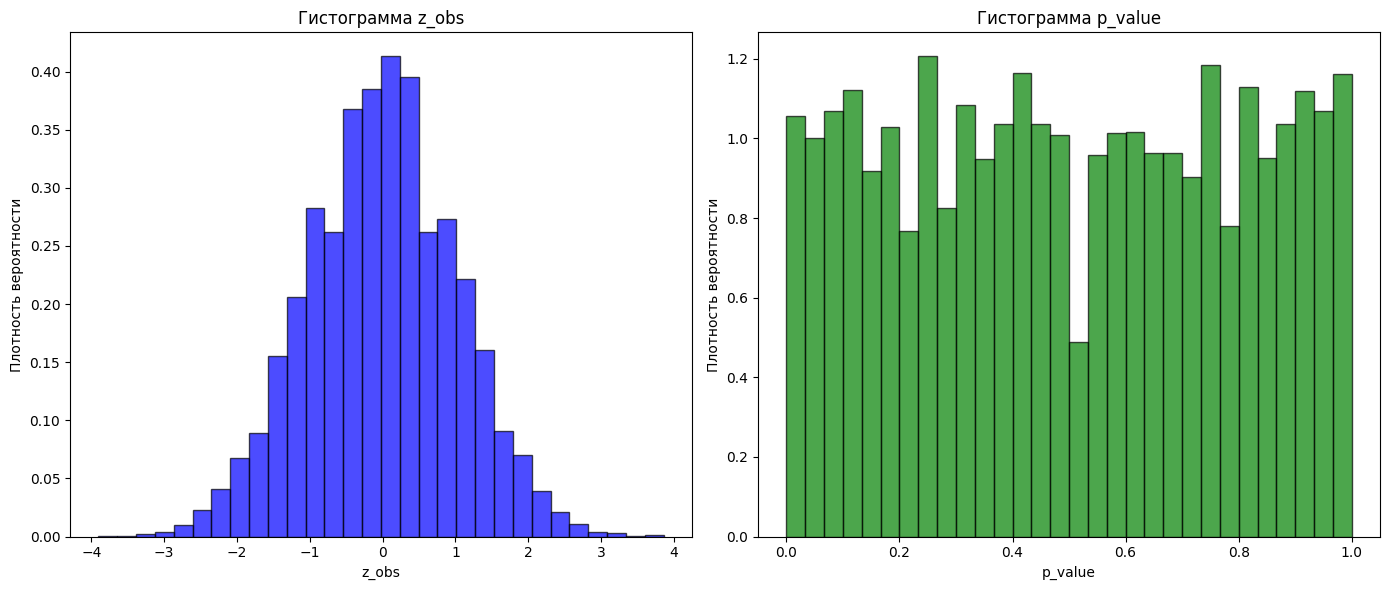

In [14]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(z_obs_array, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Гистограмма z_obs')
plt.xlabel('z_obs')
plt.ylabel('Плотность вероятности')

plt.subplot(1, 2, 2)
plt.hist(p_value_array, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')
plt.title('Гистограмма p_value')
plt.xlabel('p_value')
plt.ylabel('Плотность вероятности')

plt.tight_layout()
plt.show()

In [14]:
np.mean(z_obs)

0.312935828086375

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__ Да. 0.31 . Так как формула z_obs связана с ЦПТ, а она с нормальным распределением.

__в) [1 балл]__ Предположим, что верна альтернативная гипотеза. Доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. Как при верности нулевой гипотезы будут распределены `pvalue` и `z_obs`?  

С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$, постройте две гистограммы и прокомментируйте получившиеся результаты.

In [6]:
p *= 1.2
z_obs_list = []
p_value_list = []

for _ in range(n_samples):
    control_group, treatment_group = gen_sample(sample_size, 0, p)
    z_obs, p_value = asy_mean_test(control_group, treatment_group)
    z_obs_list.append(z_obs)
    p_value_list.append(p_value)

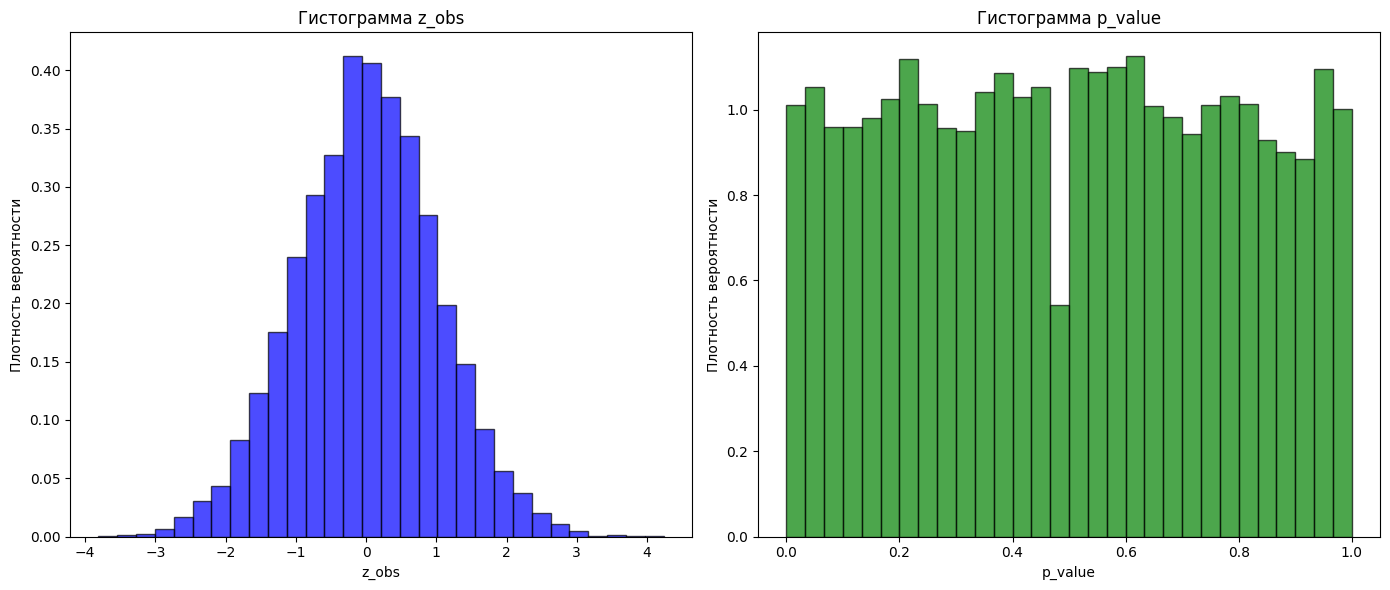

In [7]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(z_obs_array, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Гистограмма z_obs')
plt.xlabel('z_obs')
plt.ylabel('Плотность вероятности')

plt.subplot(1, 2, 2)
plt.hist(p_value_array, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')
plt.title('Гистограмма p_value')
plt.xlabel('p_value')
plt.ylabel('Плотность вероятности')

plt.tight_layout()
plt.show()

А как будут выглядеть результаты, если доля в тестовой выборке больше на $40\%$? Проведите симуляции.

In [10]:
p = 0.5 * 1.4
z_obs_list = []
p_value_list = []

for _ in range(n_samples):
    control_group, treatment_group = gen_sample(sample_size, 0, p)
    z_obs, p_value = asy_mean_test(control_group, treatment_group)
    z_obs_list.append(z_obs)
    p_value_list.append(p_value)

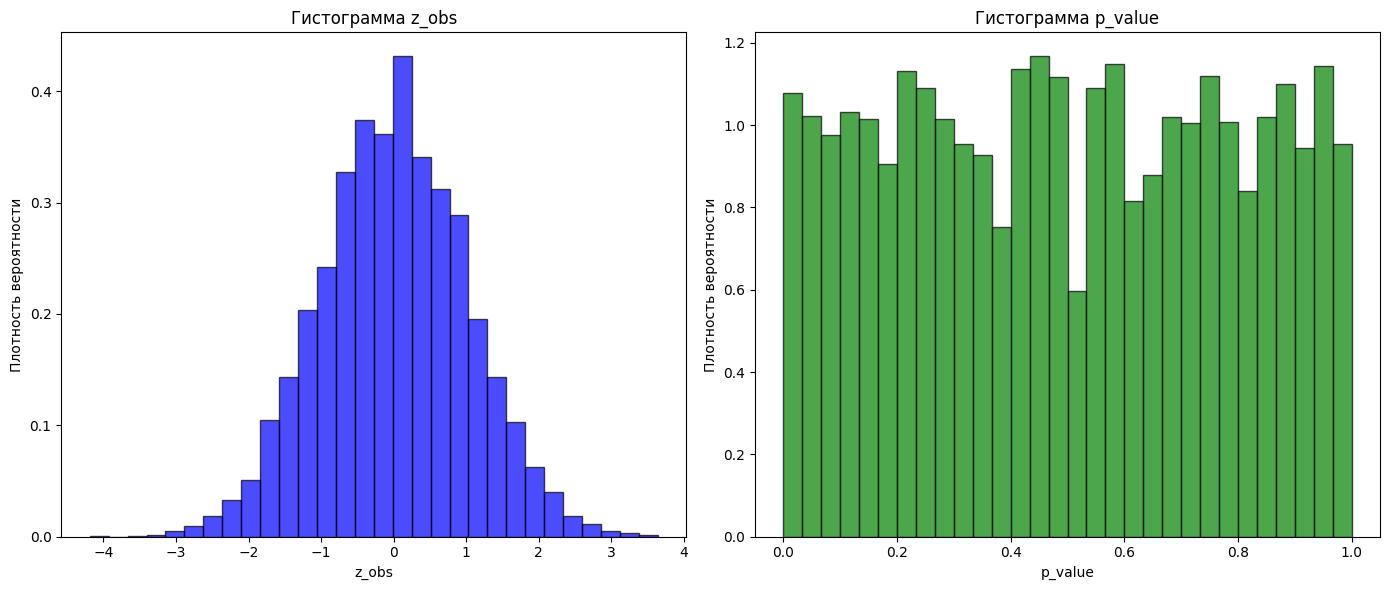

In [11]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(z_obs_array, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black')
plt.title('Гистограмма z_obs')
plt.xlabel('z_obs')
plt.ylabel('Плотность вероятности')

plt.subplot(1, 2, 2)
plt.hist(p_value_array, bins=30, density=True, alpha=0.7, color='green', edgecolor='black')
plt.title('Гистограмма p_value')
plt.xlabel('p_value')
plt.ylabel('Плотность вероятности')

plt.tight_layout()
plt.show()

In [12]:
np.mean(z_obs)

0.4375131898442451

Правда ли, что распределение `pvalue` оказалось равномерным на отрезке $[0;1]$? Какое у распределения `z_obs` математическое ожидание? Попытайтесь понятными словами пояснить, почему распределения оказались именно такими.

__Ответ:__ Да. 0.43. Z_obs немного съезжает направо. Так как мы не случайно ввели изменения между контрольной и тестовой группами

__г) [1 балл]__ Обычно, перед началом эксперимента, мы фиксируем ошибку первого рода, вероятность отвергнуть нулевую гипотезу, когда она на самом деле верна,  

$$\alpha = \mathbb{P}(H_A \text{ выбрана} \mid H_0 \text{ верна}).$$

Дальше мы принимаем решение, о том, какую гипотезу выбрать, сравнивая `z_obs` с $z_{1 - \alpha},$ либо `pvalue` с $\alpha$ (напомню что мы делаем симуляции для правосторонней альтернативы, поэтому $\alpha$ не надо делить на два).

Давайте проверим для конкретного $\alpha$, что это правда работает. Выберите любое разумное значение $\alpha$. С помощью симуляций сгенерируйте $10^4$ выборок размера $1000$ при верности нулевой гипотезы. Проверьте эти гипотезы и оцените получившееся значение $\alpha$. Правда ли, что оно оказалось равно заявленному значению?

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [16]:
alpha = 0.05
p = 0.5
z_obs_list = []
p_value_list = []

reject_null_z = 0
reject_null_p = 0

for _ in range(n_samples):
    control_group, treatment_group = gen_sample(sample_size, 0, p)
    z_obs, p_value = asy_mean_test(control_group, treatment_group)
    z_obs_list.append(z_obs)
    p_value_list.append(p_value)
    if z_obs > stats.norm.ppf(1 - alpha): 
        reject_null_z += 1
    if p_value < alpha:
        reject_null_p += 1

actual_alpha_z = reject_null_z / n_samples
actual_alpha_p = reject_null_p / n_samples

print(f"Заявленное alpha: {alpha}")
print(f"Фактическое alpha (по z_obs): {actual_alpha_z}")
print(f"Фактическое alpha (по p_value): {actual_alpha_p}")

Заявленное alpha: 0.05
Фактическое alpha (по z_obs): 0.0535
Фактическое alpha (по p_value): 0.0535


Кроме ошибки первого рода есть ещё и ошибка второго рода, вероятность остаться с нулевой гипотезой, когда верна альтернатива,

$$\beta = \mathbb{P}(H_0 \text{ выбрана} \mid H_A \text{ верна}).$$

Давайте предположим, что доля в тестовой (treatment) выборке оказалась на $20\%$ больше, чем в контрольной. С помощью симуляций того же самого объёма оцените, чему равна $\beta$.

__P.S.__ в идеале, тут надо воспользоваться уже проделанными выше симуляциями.

In [18]:
alpha = 0.05
p = 0.5 * 1.2
z_obs_list = []
p_value_list = []

fail_to_reject_z = 0
fail_to_reject_p = 0

for _ in range(n_samples):
    control_group, treatment_group = gen_sample(sample_size, 0, p)
    z_obs, p_value = asy_mean_test(control_group, treatment_group)
    z_obs_list.append(z_obs)
    p_value_list.append(p_value)
    if z_obs <= stats.norm.ppf(1 - alpha): 
        fail_to_reject_z += 1
    if p_value >= alpha:
        fail_to_reject_p += 1

actual_beta_z = fail_to_reject_z / n_samples
actual_beta_p = fail_to_reject_p / n_samples

print(f"Фактическая вероятность ошибки второго рода (по z_obs): {actual_beta_z}")
print(f"Фактическая вероятность ошибки второго рода (по p_value): {actual_beta_p}")

Фактическая вероятность ошибки второго рода (по z_obs): 0.9508
Фактическая вероятность ошибки второго рода (по p_value): 0.9508


Теперь доля в тестовой выборке оказалась на $40\%$ больше, чем в контрольной. Чем равна $\beta$ здесь?

In [19]:
alpha = 0.05
p = 0.5 * 1.4
z_obs_list = []
p_value_list = []

fail_to_reject_z = 0
fail_to_reject_p = 0

for _ in range(n_samples):
    control_group, treatment_group = gen_sample(sample_size, 0, p)
    z_obs, p_value = asy_mean_test(control_group, treatment_group)
    z_obs_list.append(z_obs)
    p_value_list.append(p_value)
    if z_obs <= stats.norm.ppf(1 - alpha): 
        fail_to_reject_z += 1
    if p_value >= alpha:
        fail_to_reject_p += 1

actual_beta_z = fail_to_reject_z / n_samples
actual_beta_p = fail_to_reject_p / n_samples

print(f"Фактическая вероятность ошибки второго рода (по z_obs): {actual_beta_z}")
print(f"Фактическая вероятность ошибки второго рода (по p_value): {actual_beta_p}")

Фактическая вероятность ошибки второго рода (по z_obs): 0.9485
Фактическая вероятность ошибки второго рода (по p_value): 0.9485


Что с ошибкой второго рода происходит при росте эффекта? Что происходит с ней, если при проверке гипотезы взять более маленькое $\alpha$?

__Ответ:__ Уменьшаетася. Так как alpha коррелириует с beta

__д) [1 балл]__ Ошибки $\alpha$ и $\beta$ связаны между собой. Чем выше, при фиксированном размере выборки и эффекта мы делаем одну, тем ниже другая. Давайте попробуем в рамках проделанных выше симуляций нарисовать взаимосвязь между ошибками.

Выше, для оценки $\beta$ вы сравнивали вектор `pval` с зафиксированным значением `alpha`.  Переберите `alpha` по циклу от 0 до 1 с шагом 0.01 и оцените для каждого значения `alpha` значение `beta`.

Нарисуйте получившуюся взаимосвязь на графике для эффекта в 20% и 40%. Какая из кривых идёт ниже?

In [4]:
import tqdm

In [34]:
p_c = 0.5       

alphas = np.arange(0, 1.01, 0.01)
betas_20 = []
betas_40 = []
p_values_20 = []
p_t_20 = p_c * 1.2  
for alpha in tqdm.tqdm(alphas):
    fail_to_reject_20 = 0
    for _ in range(n_samples):
        control_group = np.random.binomial(n=1, p=p_c, size=sample_size)
        treatment_group = np.random.binomial(n=1, p=p_t_20, size=sample_size)
        
        p_control = np.mean(control_group)
        p_treatment = np.mean(treatment_group)
        
        z_obs = (p_treatment - p_control) / np.sqrt((p_control * (1 - p_control) / sample_size) + (p_treatment * (1 - p_treatment) / sample_size))
        p_value = stats.norm.sf(z_obs) 
        p_values_20.append(p_value)
        if p_value >= alpha:  
            fail_to_reject_20 += 1
            
    beta_20 = fail_to_reject_20 / n_samples
    betas_20.append(beta_20)

100%|██████████| 101/101 [03:04<00:00,  1.82s/it]


In [35]:
p_t_40 = p_c * 1.4  
p_values_40 = []
for alpha in alphas:
    fail_to_reject_40 = 0
    for _ in range(n_samples):
        control_group = np.random.binomial(n=1, p=p_c, size=sample_size)
        treatment_group = np.random.binomial(n=1, p=p_t_40, size=sample_size)
        
        p_control = np.mean(control_group)
        p_treatment = np.mean(treatment_group)
        
        z_obs = (p_treatment - p_control) / np.sqrt((p_control * (1 - p_control) / sample_size) + (p_treatment * (1 - p_treatment) / sample_size))
        p_value = stats.norm.sf(z_obs) 
        p_values_40.append(p_value)
        if p_value >= alpha:
            fail_to_reject_40 += 1
            
    beta_40 = fail_to_reject_40 / n_samples
    betas_40.append(beta_40)

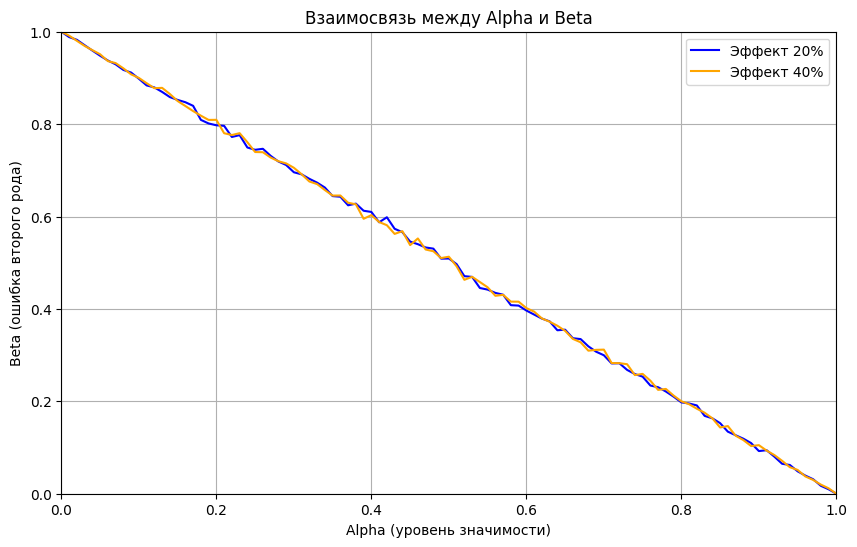

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(alphas, betas_20, label='Эффект 20%', color='blue')
plt.plot(alphas, betas_40, label='Эффект 40%', color='orange')
plt.xlabel('Alpha (уровень значимости)')
plt.ylabel('Beta (ошибка второго рода)')
plt.title('Взаимосвязь между Alpha и Beta')
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

Нарисуйте точно такую же кривую для ситуации, когда была верна нулевая гипотеза.

In [36]:
p_c = 0.5  
p_t = 0.5  

betas_null = []
p_values_null = []
for alpha in tqdm.tqdm(alphas):
    fail_to_reject_null = 0
    for _ in range(n_samples):
        control_group = np.random.binomial(n=1, p=p_c, size=sample_size)
        treatment_group = np.random.binomial(n=1, p=p_t_20, size=sample_size)
        
        p_control = np.mean(control_group)
        p_treatment = np.mean(treatment_group)
        
        z_obs = (p_treatment - p_control) / np.sqrt((p_control * (1 - p_control) / sample_size) + (p_treatment * (1 - p_treatment) / sample_size))
        p_value = stats.norm.sf(z_obs) 
        p_values_null.append(p_value)
        
        if p_value >= alpha:  
            fail_to_reject_null += 1
            
    beta_null = fail_to_reject_null / n_samples
    betas_null.append(beta_null)

100%|██████████| 101/101 [03:03<00:00,  1.82s/it]


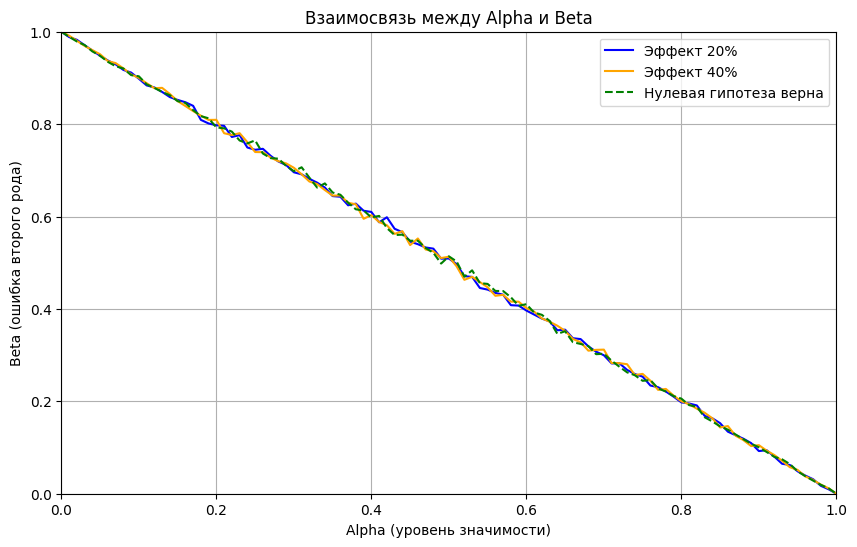

In [27]:
plt.figure(figsize=(10, 6))

plt.plot(alphas, betas_20, label='Эффект 20%', color='blue')
plt.plot(alphas, betas_40, label='Эффект 40%', color='orange')
plt.plot(alphas, betas_null, label='Нулевая гипотеза верна', color='green', linestyle='--')

plt.xlabel('Alpha (уровень значимости)')
plt.ylabel('Beta (ошибка второго рода)')
plt.title('Взаимосвязь между Alpha и Beta')
plt.legend()
plt.grid()
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

Вместо осей $(\alpha, \beta)$ обычно такой график рисуют в осях $(\alpha, 1 - \beta)$. Давайте построим его и проинтерпретируем.

In [37]:
pvalue_data = {
    'Эффект 20%': np.array(p_values_20),
    'Эффект 40%': np.array(p_values_40),
    'Нулевая гипотеза верна': np.array(p_values_null)
}

In [5]:
def plot_pvalue_distribution(dict_pvalues):
    xseq = np.linspace(0, 1, 1000)

    for key, pvalues in dict_pvalues.items():
        yseq = [np.mean(pvalues < x) for x in xseq]
        plt.plot(xseq, yseq, label=key)

    plt.plot([0, 1], [0, 1], '--k', alpha=0.8)
    plt.title('Распределение p-value/ROC-кривая', size=16)
    plt.xlabel('alpha', size=12)
    plt.ylabel('1 - beta', size=12)
    plt.legend(fontsize=12)
    plt.grid()

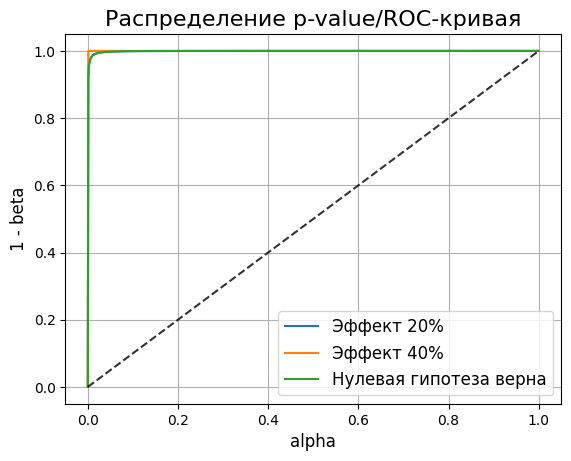

In [39]:
plot_pvalue_distribution(pvalue_data)
plt.show()

Заполните пропуски в коде ниже, чтобы для нашего АБ-теста отрисовались ROC-кривые.

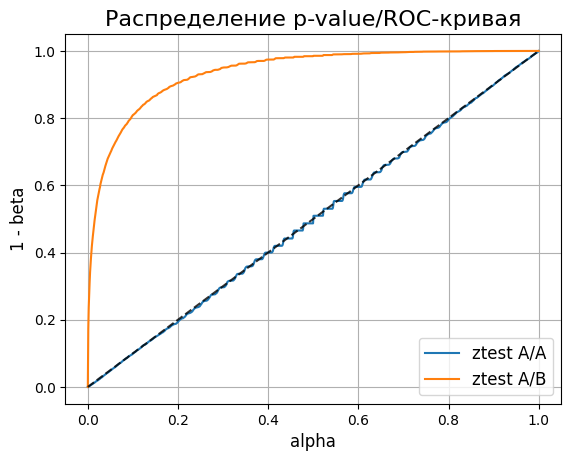

In [8]:
n_sim = 10**4
sample_size = 1000

dict_pvalues = defaultdict(list)
for _ in range(n_sim):

    x_control, x_treatment = gen_sample(sample_size, 0.2, 0.2)
    z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)

    # сгенерируем ещё одну тестовую выборку, чтобы убедиться, что в случае когда выборки совпали,
    # наш тест работает корректно и не находит разницу
    x_control_again, _ = gen_sample(sample_size, 0.2, 0.2)
    z_obs_aa, pval_aa = asy_mean_test(x_control_again, x_treatment)

    x_control_again, _ = gen_sample(sample_size, 0, 0.2)
    z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)

    dict_pvalues['ztest A/A'].append(pval_aa)
    dict_pvalues['ztest A/B'].append(pval_ab)

plot_pvalue_distribution(dict_pvalues)

Получившийся график можно проинтерпретировать двумя способами. Мы много-много раз проводим АБ-тест. В начале теста мы зафиксировали какую-то $\alpha$ и дальше проверяем кучу гипотез.

1. Линия `ztest A/A` это функция распределения pvalue при верности нулевой гипотезы. Оно было равномерным, мы двигаем $\alpha$ по оси $OX$ и оцениваем $\mathbb{P}(\text{pvalue} \le \alpha) = F(\alpha)$.  

По аналогии, линия `ztest A/B` это функция распределения pvalue при верности альтернативной гипотезы.

2. Линию `ztest A/B` можно проинтерпретировать как ROC-кривую. Если вы уже знаете про задачу классификации из машинного обучения, то это ровно оно. Полнота это $1 - \beta$, то есть то, сколько верных альтернативных гипотез мы найдём, если будем использовать наш АБ-тест, FPR это $\alpha$, то есть то, сколько верных нулевых гипотез мы заберём с собой в альтернативные. Эту величину мы определяем до старта эксперимента.

> Важно: если вы не поняли интерпретацию из пункта 2, просто забейте. Заботаете МО, поймёте. Интерпретацию из пункта 1 должны понять все. Если вы её не поняли, время напрячься и подумать ещё разок.

__Что для нас важно:__

- Чем выпуклее график, тем лучше мы находим эффект и процедура проверки гипотезы работае корректно;
- Чем больше у нас наблюдений тем выпуклее график;
- Чем сильнее в тестовой выборке подскакивает $p_t$ при изменениях, тем легче нам найти эффект и тем выпуклее график;
- Если $p_t$ подскочило на очень маленькую величину, нам сложнее найти это изменение, и график будет менее выпуклым;
- Чем меньше в выборках дисперсия, тем выпуклее график.

__е) [2 балла]__ При верности альтернативной гипотезы, постройте ROC-кривые из пункта выше для разного числа наблюдений в выборке: 10, 100, 1000, 10000 при любом фиксированном эффекте.

/tmp/ipykernel_31/907377542.py:11: RuntimeWarning: invalid value encountered in scalar divide
  z_obs = (mean_t - mean_c) / std_est
/tmp/ipykernel_31/107004048.py:5: RuntimeWarning: invalid value encountered in greater
  yseq = [np.mean(pvalues < x) for x in xseq]


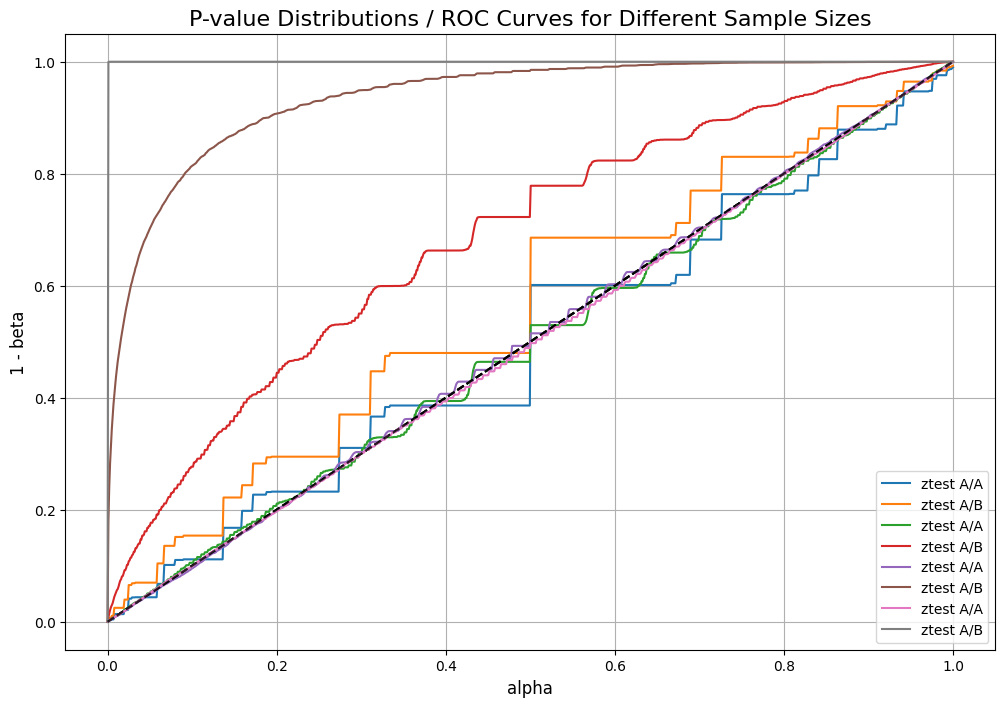

In [10]:
effect = 0.2
p_control = 0.2
sample_sizes = [10, 100, 1000, 10000]

all_pvalues = defaultdict(list)

for sample_size in sample_sizes:
    dict_pvalues = defaultdict(list)

    for _ in range(n_sim):
        
        x_control, x_treatment = gen_sample(sample_size, 0.2, 0.2)
        z_obs_ab, pval_ab = asy_mean_test(x_control, x_treatment)
    
        # сгенерируем ещё одну тестовую выборку, чтобы убедиться, что в случае когда выборки совпали,
        # наш тест работает корректно и не находит разницу
        x_control_again, _ = gen_sample(sample_size, 0.2, 0.2)
        z_obs_aa, pval_aa = asy_mean_test(x_control_again, x_treatment)
    
        x_control_again, _ = gen_sample(sample_size, 0, 0.2)
        z_obs_aa, pval_aa = asy_mean_test(x_control, x_control_again)
        
        dict_pvalues['ztest A/A'].append(pval_aa)
        dict_pvalues['ztest A/B'].append(pval_ab)

    all_pvalues[f'Sample Size = {sample_size}'] = dict_pvalues

plt.figure(figsize=(12, 8))
for label, dict_pvalue in all_pvalues.items():
    plot_pvalue_distribution(dict_pvalue)

plt.title('P-value Distributions / ROC Curves for Different Sample Sizes', size=16)
plt.xlabel('alpha', size=12)
plt.ylabel('1 - beta', size=12)
plt.legend()
plt.grid()
plt.show()

__ё) [1 балл]__ Количество наблюдений, ошибка 1 и 2 рода, размер эффекта, который мы ищем и дисперсия в выборках связаны между собой. Для некоторых критериев проверки гипотез можно вывести формулы, которые их связывают.

В данном случае, формула для расчета числа наблюдений _для одной группы_ выглядит вот так:

$$
n_{\text{one group}} = \frac{(\sigma_A^2 + \sigma_B^2) \cdot (z_{1-\frac{\alpha}{2}} + z_{1-\beta})^2}{MDE^2},
$$

В приложении Яндекс.Такси в конце поездки вылезают рандомные опросники. В одном из опросников задаётся вопрос «А вы пристёгивались, когда ехали?»

В России, в день, в Такси происходит 1 миллион заказов. Вопрос про ремни задаётся рандомным 10% пользователей, закончивших поездку. Пользователь не игнорирует опросник и отвечает на него да или нет с вероятностью 5% (цифры взяты из головы и не отражают реальную статистику).

Менеджер Екатерина хочет сделать так, чтобы когда пассажир садится в машину, Алиса просила его пристегнуться. Хочется замерить, какой эффект это даст на пристёгивания. Станут ли люди чаще пристёгиваться. Замерять мы это будем опросником. Сейчас 10% пользователей говорят, что пристегнулись.

Екатерина пришла к вам и между вами состоялся следующий диалог:

- Хочу АБ-тест с разбивкой 50 на 50.
- Какие ошибки 1 и 2 рода хочешь?
- Нулевые.
- Нам надо бесконечно наблюдений, готова столько ждать?
- Нет.
- На сколько мы хотим, чтобы выросла доля ответов да?
- Если подрастёт хотябы на процент, будет круто.
- То есть если меньше процента, такой эффект считаем неудачей и отсутствием изменения?
- Да.
- Давай я нарисую тебе табличку с разными ошибками, а внутри на пересечении напишу сколько дней надо ждать, чтобы найти такой минимальный эффект.
- Давай, по ней и примем решение.

Нарисуйте для Екатерины такую табличку. Не забудьте перевести общее количество наблюдений в дни.

In [12]:
import pandas as pd
p1 = 0.10 
p2 = 0.11 

alphas = [0.01, 0.05, 0.10]  
betas = [0.1, 0.2, 0.25]     

def calculate_sample_size(p1, p2, alpha, beta):
    z_alpha = stats.norm.ppf(1 - alpha / 2)  
    z_beta = stats.norm.ppf(1 - beta)
    
    n = ((z_alpha + z_beta) ** 2 * (p1 * (1 - p1) + p2 * (1 - p2))) / (p2 - p1) ** 2
    return np.ceil(n)

results = []

for alpha in alphas:
    row = []
    for beta in betas:
        n = calculate_sample_size(p1, p2, alpha, beta)
        days = n / (1000000 * 0.1)  
        row.append(days)
    results.append(row)

table = pd.DataFrame(results, columns=[f'Beta = {beta}' for beta in betas], index=[f'Alpha = {alpha}' for alpha in alphas])
print(table)

              Beta = 0.1  Beta = 0.2  Beta = 0.25
Alpha = 0.01     0.27959     0.21945      0.19851
Alpha = 0.05     0.19744     0.14749      0.13041
Alpha = 0.1      0.16092     0.11618      0.10108


__ж) [1 балл]__ Попробуем сломать наш АБ-тест. Когда мы используем z-тест, мы размышляем в терминах центральной предельной теоремы. Тест будет работать, если выполнены предпосылки ЦПТ:

- Наблюдения независимо одинаково распределены
- В данных нет выборосов, дисперсия конечная
- Данных много

Давайте сломаем одно из условий и попробуем собрать выборку из [распределения Парето](https://ru.wikipedia.org/wiki/Распределение_Парето).

In [ ]:
def gen_sample(n_obs, effect, b=0.5):
    x_control = stats.pareto(b=b).rvs(n_obs)
    x_treatment = stats.pareto(b=b).rvs(n_obs)
    x_treatment = (1 + effect) * x_treatment
    return x_control, x_treatment

Отрисуйте ROC-кривые для $b=3$, $b=1$, $b=0.5$

In [ ]:
# ваш код

Возьмите при каждом $b$ одну выборку, нарисуйте для неё гистограмму и посмотрите как обстоят дела с выбросами.

In [ ]:
# ваш код

У распределения Парето не всегда существует дисперсия. Это ломает предпосылки ЦПТ и АБ-тест разваливается.

Возникает вполне резонный вопрос: а что делать в таких ситуациях? Есть несколько дорог.

- Во-первых, можно отвязаться от математического ожидания и поработать с медианой. Для неё тоже можно вывести асимптотическое распределение с помощью дельта-метода.
- Во-вторых, можно попробовать другие техники проверки гипотез. Например, бутстрап и непараметрические критерии.

Об этом мы и будем говорить на следующих парах.